<a href="https://colab.research.google.com/github/ruizleandro/Credit_Card_Default_Clients/blob/master/Credit_Card_Default_Clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Project Objectives

The main objective of this project is to predict if a client of a bank will default their payments using information from the last 6 months.

## Necessary installations

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Downgrading Java so Spark works properly

In [63]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


###### Spark Installation

In [64]:
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(
    'portfolio_default_of_credit_card_clients').getOrCreate()

     |████████████████████████████████| 204.7MB 84kB/s 
     |████████████████████████████████| 204kB 51.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=dc4788f4e20fd80463bab669d06b3e03331abe6ccc87d325f0798cfbaaba1460
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


# Getting the data

[Link to dataset's Kaggle page](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)


In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving default_of_credit_card_clients.xls to default_of_credit_card_clients.xls
User uploaded file "default_of_credit_card_clients.xls" with length 5539328 bytes


In [12]:
df = pd.read_excel("default_of_credit_card_clients.xls", skiprows=1)
df.set_index('ID', inplace=True)

# Data Cleaning

 ## Variable description

There are 25 variables:

* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Gender (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Marital status (1=married, 2=single, 3=others)
* AGE: Age in years
* PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
* PAY_2: Repayment status in August, 2005 (scale same as above)
* PAY_3: Repayment status in July, 2005 (scale same as above)
* PAY_4: Repayment status in June, 2005 (scale same as above)
* PAY_5: Repayment status in May, 2005 (scale same as above)
* PAY_6: Repayment status in April, 2005 (scale same as above)
* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
* default.payment.next.month: Default payment (1=yes, 0=no)

## Feature edition

I'll change the name of the target column and the name of `PAY_0` to `PAY_1` just for simplicity sake.

In [13]:
df = df.rename(columns={'default payment next month': 'default', 
                        'PAY_0': 'PAY_1'})

In the variable description we can see that a value of `-1` on `PAY_N` means pay duly, so it has more sense if I change that value to `0`, meaning that the client doesn't have payment delay. And the value `-2` is undocumented, but we can guess that means the same as `-1`.

In [14]:
df.loc[df.PAY_1 == -2, 'PAY_1'] = 0
df.loc[df.PAY_1 == -1, 'PAY_1'] = 0
df.loc[df.PAY_2 == -2, 'PAY_2'] = 0
df.loc[df.PAY_2 == -1, 'PAY_2'] = 0
df.loc[df.PAY_3 == -2, 'PAY_3'] = 0
df.loc[df.PAY_3 == -1, 'PAY_3'] = 0
df.loc[df.PAY_4 == -2, 'PAY_4'] = 0
df.loc[df.PAY_4 == -1, 'PAY_4'] = 0
df.loc[df.PAY_5 == -2, 'PAY_5'] = 0
df.loc[df.PAY_5 == -1, 'PAY_5'] = 0
df.loc[df.PAY_6 == -2, 'PAY_6'] = 0
df.loc[df.PAY_6 == -1, 'PAY_6'] = 0

I am going to group the label `MARRIAGE = 0` (that is undocumented) with `MARRAIAGE = 3` (others). 

In [15]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

And I'll do the same with `EDUCATION = 0` (undocumented), `EDUCATION = 5` (unknown), and `EDUCATION = 6` (also unknown). I am going to group all this labels in `EDUCATION = 4` (others).

In [16]:
df.loc[(df.EDUCATION == 0) | (df.EDUCATION == 5) | (df.EDUCATION == 6),
       'EDUCATION'] = 4
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

# Exploratory Data Analysis

### Shape and quick look to the dataset

In [40]:
df.shape

(30000, 25)

In [41]:
df.head(10) 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,AGE_BIN
ID,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1
2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,3
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,3
5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,5
6,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0,3
7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0,2
8,100000,2,2,2,23,0,0,0,0,0,0,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,1
9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0,2


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LIMIT_BAL  30000 non-null  int64   
 1   SEX        30000 non-null  int64   
 2   EDUCATION  30000 non-null  int64   
 3   MARRIAGE   30000 non-null  int64   
 4   AGE        30000 non-null  int64   
 5   PAY_1      30000 non-null  int64   
 6   PAY_2      30000 non-null  int64   
 7   PAY_3      30000 non-null  int64   
 8   PAY_4      30000 non-null  int64   
 9   PAY_5      30000 non-null  int64   
 10  PAY_6      30000 non-null  int64   
 11  BILL_AMT1  30000 non-null  int64   
 12  BILL_AMT2  30000 non-null  int64   
 13  BILL_AMT3  30000 non-null  int64   
 14  BILL_AMT4  30000 non-null  int64   
 15  BILL_AMT5  30000 non-null  int64   
 16  BILL_AMT6  30000 non-null  int64   
 17  PAY_AMT1   30000 non-null  int64   
 18  PAY_AMT2   30000 non-null  int64   
 19  PAY_AMT3   30000 non-null

### Correlation Matrix

In [43]:
corr_matrix = df.corr()
corr_matrix['default'].sort_values(ascending=False)

default      1.000000
PAY_1        0.396019
PAY_2        0.327093
PAY_3        0.286999
PAY_4        0.269055
PAY_5        0.260850
PAY_6        0.244437
EDUCATION    0.033842
AGE          0.013890
BILL_AMT6   -0.005372
BILL_AMT5   -0.006760
BILL_AMT4   -0.010156
BILL_AMT3   -0.014076
BILL_AMT2   -0.014193
BILL_AMT1   -0.019644
MARRIAGE    -0.027575
SEX         -0.039961
PAY_AMT6    -0.053183
PAY_AMT5    -0.055124
PAY_AMT3    -0.056250
PAY_AMT4    -0.056827
PAY_AMT2    -0.058579
PAY_AMT1    -0.072929
LIMIT_BAL   -0.153520
Name: default, dtype: float64

Heatmap of the correlation matrix:

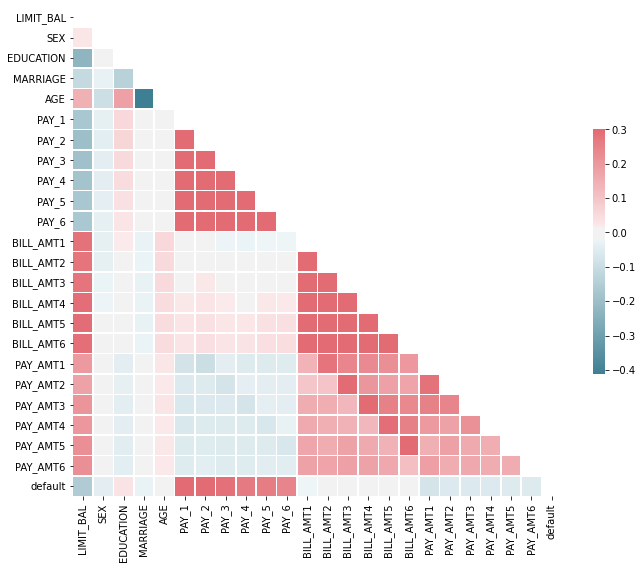

In [44]:
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Exploration

### Description of categorical features:

Here, I have to count the values of every categorical variabel (SEX, AGE, EDUCATION and MARRIAGE).

#### Gender

* 1 corresponds to MEN.
* 2 corresponds to WOMEN.

Value counts:

In [45]:
print(df.SEX.value_counts(), '\n')
print('Women are the', (sum(df.SEX == 2) * 100 / 30000), '% of the samples.')

2    18112
1    11888
Name: SEX, dtype: int64 

Women are the 60.373333333333335 % of the samples.


Default probabilities according to the gender of the clients:

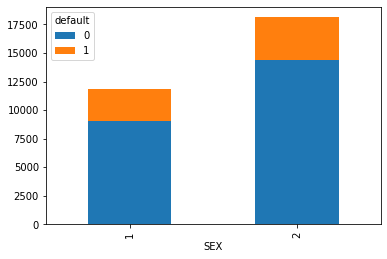

In [46]:
gender = df.groupby(['SEX', 'default']).size().unstack(1)
gender.plot(kind='bar', stacked = True)

In [47]:
gender['probability'] = (gender[1]/(gender[0] + gender[1]))
gender

default,0,1,probability
SEX,,,
1,9015,2873,0.241672
2,14349,3763,0.207763


We can see that men are 20 % more likely to default than women.



---



#### Education

* 1 corresponds to school graduated.
* 2 corresponds to university graduated.
* 3 corresponds to high school graduated.
* 4 corresponds to others.

Value counts:

In [48]:
print(df.EDUCATION.value_counts(), '\n')
print('The', (sum(df.EDUCATION == 1) * 100 / 30000), 
      '% of the clients are school graduates.')
print('The', (sum(df.EDUCATION == 2) * 100 / 30000), 
      '% of the clients are university graduates.')
print('The', (sum(df.EDUCATION == 3) * 100 / 30000), 
      '% of the clients are high school graduates.')
print('The', (sum(df.EDUCATION == 4) * 100 / 30000), 
      '% of the clients have other education level.')

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64 

The 35.28333333333333 % of the clients are school graduates.
The 46.766666666666666 % of the clients are university graduates.
The 16.39 % of the clients are high school graduates.
The 1.56 % of the clients have other education level.


Default probabilities according to education of the clients:

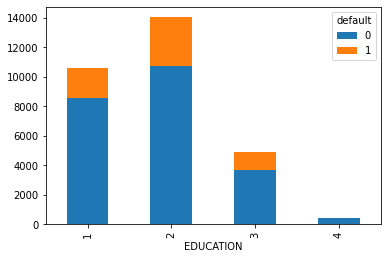

In [49]:
default_by_education = df.groupby(['EDUCATION', 'default']).size().unstack(1)
default_by_education.plot(kind='bar', stacked = True)

In [50]:
default_by_education['probability'] = (default_by_education[1]/
                                      (default_by_education[0] +
                                       default_by_education[1]))
default_by_education

default,0,1,probability
EDUCATION,,,
1,8549,2036,0.192348
2,10700,3330,0.237349
3,3680,1237,0.251576
4,435,33,0.070513


Surprisingly, we can see that clients that only completed high school are more likely to default than university graduates.



---



#### Marriage


* 1 corresponds to married clients.
* 2 corresponds to single clients.
* 3 corresponds to clients with other marital status.

Value counts:

In [51]:
print(df.MARRIAGE.value_counts(), '\n')
print('The', (sum(df.MARRIAGE == 1) * 100 / 30000), 
      '% of the clients are married.')
print('The', (sum(df.MARRIAGE == 2) * 100 / 30000), 
      '% of the clients are single.')
print('The', (sum(df.MARRIAGE == 3) * 100 / 30000), 
      '% of the clients have other marital status.')

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64 

The 45.53 % of the clients are married.
The 53.21333333333333 % of the clients are single.
The 1.2566666666666666 % of the clients have other marital status.


Default probabilities according to the marital status of the clients:

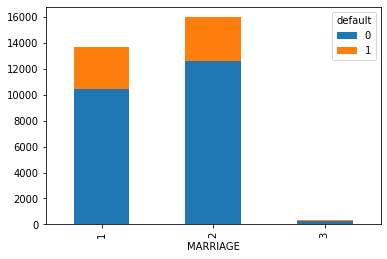

In [52]:
default_marriage = df.groupby(['MARRIAGE', 'default']).size().unstack(1)
default_marriage.plot(kind='bar', stacked = True)

In [53]:
default_marriage['probability'] = (default_marriage[1]/
                                  (default_marriage[0] + 
                                   default_marriage[1]))
default_marriage

default,0,1,probability
MARRIAGE,,,
1,10453,3206,0.234717
2,12623,3341,0.209283
3,288,89,0.236074


We can see that single clients have less probabilities of default than clients that are married or have other marital status.



---



### Numerical features

#### Age

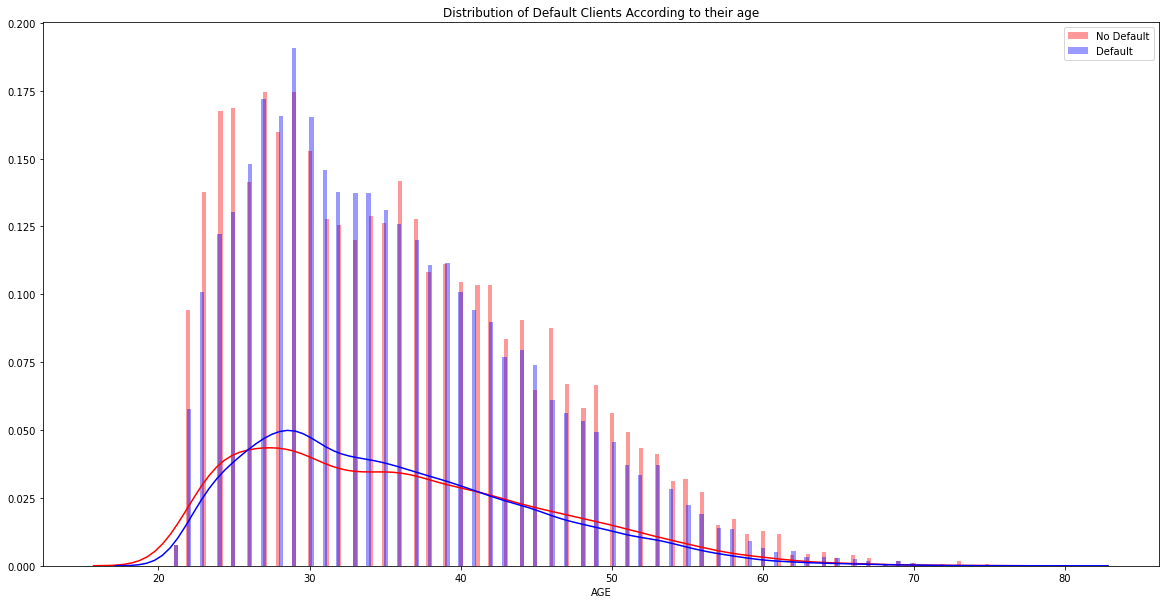

In [54]:
class_0 = df.loc[df['default'] == 0]["AGE"]
class_1 = df.loc[df['default'] == 1]["AGE"]
plt.figure(figsize = (20,10))
plt.title('Distribution of Default Clients According to their age')
sns.set_color_codes("pastel")
sns.distplot(class_1, kde=True, bins=200, color="red", label='No Default')
sns.distplot(class_0, kde=True, bins=200, color="blue", label='Default')
plt.legend()
plt.show()

#### Billing Amount

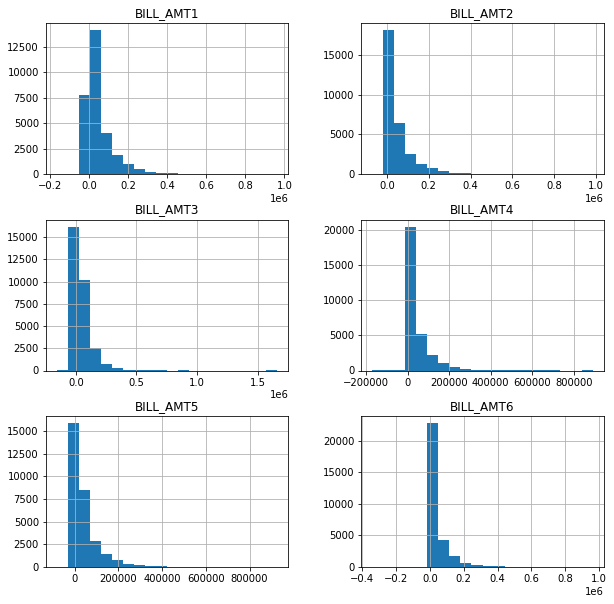

In [55]:
bills = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]

bills.hist(bins=20, figsize=(10,10))
plt.show()

#### Payment Amount

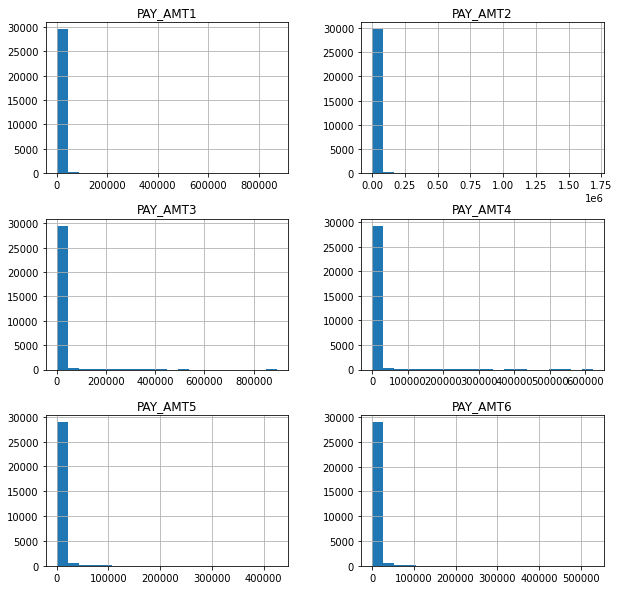

In [56]:
payments = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
               'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
payments.hist(bins=20, figsize=(10,10))
plt.show()

#### Months Owed

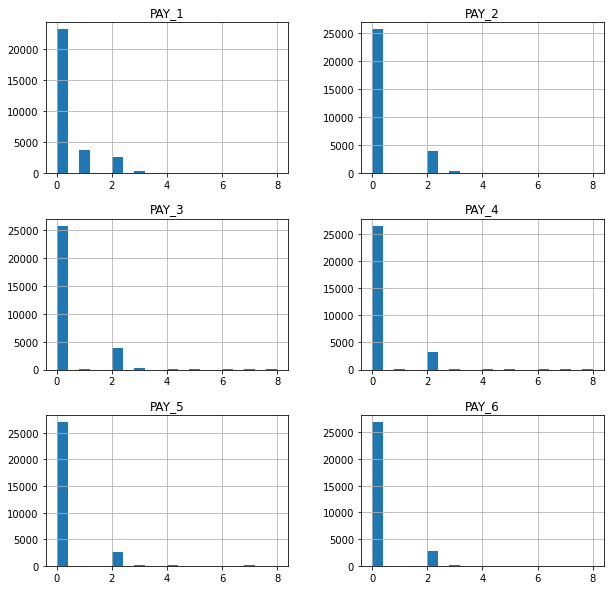

In [57]:
late = df[['PAY_1', 'PAY_2', 'PAY_3',
           'PAY_4', 'PAY_5', 'PAY_6']]

late.hist(bins=20, figsize=(10,10))
plt.show()

#### Default According to Credit Limit

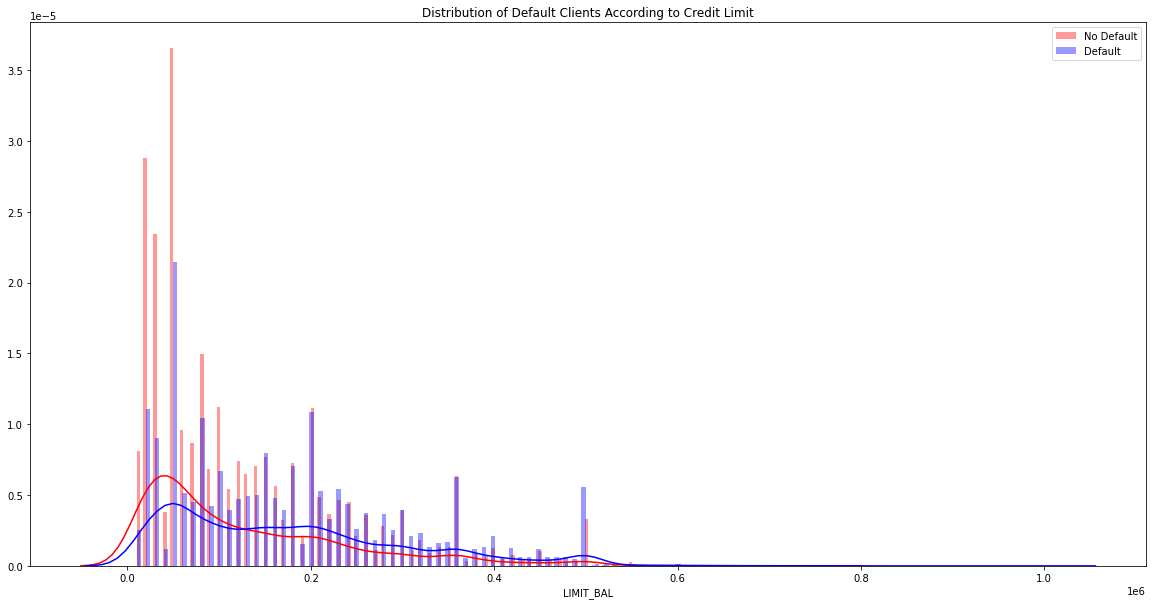

In [58]:
class_0 = df.loc[df['default'] == 0]["LIMIT_BAL"]
class_1 = df.loc[df['default'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (20,10))
plt.title('Distribution of Default Clients According to Credit Limit')
sns.set_color_codes("pastel")
sns.distplot(class_1, kde=True, bins=200, color="red", label='No Default')
sns.distplot(class_0, kde=True, bins=200, color="blue", label='Default')
plt.legend()
plt.show()

In this graph we can see that the proportion of defaults according to the credit limit starts to go up around the $10,000 limit (the bast majority is below this limit). Above that limit, more than the half of the clients end defaulting.

## Summary of the Exploratory Data Analysis

* Male clients and those who only are high school graduates are more prone to default their credit card payments.
* More than half of customers with a monthly limit of more than $ 10,000 ends up in default.
* You might think that younger clients would be more likely to default, but the data shows that clients in their 30s are the most likely to default.

# Data Preprocessing

The preprocessing of the data is a very important step before pass it through algorithm. We need to adjust the features of our set so that the data representation is more suitable for these algorithms. For example, some machine learning algorithms, like Neural Networks and Support Vector Machines, are very sensitive to the scaling of the data.

### Age Bining

Next, I'll bin the `age` feature so we have a good idea of to what age group every client belongs, but without having to deal with a lot of unique values.

In [59]:
df['AGE_BIN'] = pd.qcut(df['AGE'], 5)
df.AGE_BIN.value_counts()

(31.0, 37.0]      6728
(20.999, 27.0]    6604
(43.0, 79.0]      5986
(27.0, 31.0]      5626
(37.0, 43.0]      5056
Name: AGE_BIN, dtype: int64

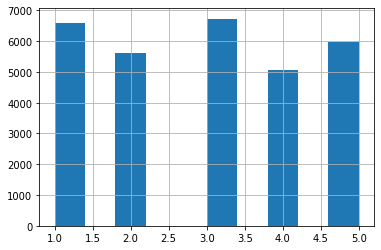

In [60]:
bins_names = [1, 2, 3, 4, 5]
df['AGE_BIN'] = pd.qcut(df['AGE'], 5, labels=bins_names)
df.AGE_BIN.hist()

### Encoding Categorical Variables

I need to encode the categorical features (that in this case have a numerical value), because as they are categories they lack of order against each other.

In [61]:
gender_dummies = pd.get_dummies(df.SEX, prefix='SEX')
education_dummies = pd.get_dummies(df.EDUCATION, prefix='EDUCATION')
marriage_dummies = pd.get_dummies(df.MARRIAGE, prefix='MARRIAGE')

binned_df = df.join(gender_dummies).join(education_dummies).join(
    marriage_dummies)

binned_df = binned_df.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
binned_df

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,AGE_BIN,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1,1,0,1,0,1,0,0,1,0,0
2,120000,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,1,0,1,0,1,0,0,0,1,0
3,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,3,0,1,0,1,0,0,0,1,0
4,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,3,0,1,0,1,0,0,1,0,0
5,50000,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,5,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,4,1,0,0,0,1,0,1,0,0
29997,150000,43,0,0,0,0,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,4,1,0,0,0,1,0,0,1,0
29998,30000,37,4,3,2,0,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,3,1,0,0,1,0,0,0,1,0


## Vector Assembler

Since I'm going to use Spark for model building, and their supervised learning algorithms need a data input with a special format. Where the dataframe has two columns: 'features', where all the features are condensed into a single dense vector representation. And 'label',  with the actual target class for every sample.

In [65]:
# enable apache_arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# create spark dataframe
df = spark.createDataFrame(binned_df)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/conversion.py:289: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.15.1 must be installed; however, your version was 0.14.1.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [66]:
from pyspark.ml.feature import VectorAssembler

df_assembler = VectorAssembler(inputCols=['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2',
                                          'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                                          'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
                                          'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                                          'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                                          'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                                          'AGE_BIN', 'SEX_1', 'SEX_2',
                                          'EDUCATION_1', 'EDUCATION_2',
                                          'EDUCATION_3', 'MARRIAGE_1',
                                          'MARRIAGE_2', 'MARRIAGE_3'],
                              outputCol='features')

df = df_assembler.transform(df)

In [67]:
df = df.withColumnRenamed('DEFAULT', 'label')

In [68]:
df.show(10, False)

+---------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-----+-------+-----+-----+-----------+-----------+-----------+-----------+----------+----------+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|LIMIT_BAL|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|label|AGE_BIN|SEX_1|SEX_2|EDUCATION_1|EDUCATION_2|EDUCATION_3|EDUCATION_4|MARRIAGE_1|MARRIAGE_2|MARRIAGE_3|features                                                                                                                                                                                      |
+---------+---+-----+-----+-----+-----+-----+-----+---------+---------+-

In [69]:
model_df = df.select(['features', 'label'])

## Data Splitting

I am going to split the dataset into a training and test set.

In [70]:
train, test = model_df.randomSplit([0.75, 0.25])

# Model Selection

## Linear Regression Model



First, I will use a simple binary classification algorithm: `LogisticRegression`.

I'll use Apache Spark for the model building, mainly because is faster than the Scikit-Learn algorithms. 

### Model Training

In [71]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
logreg = LogisticRegression().fit(train)

In [72]:
logreg.params

[Param(parent='LogisticRegression_08921cfb59fb', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_08921cfb59fb', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_08921cfb59fb', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_08921cfb59fb', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_08921cfb59fb', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_08921cfb59fb', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_08921cfb59fb', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound cons

### Model Performance on Training Set

In [73]:
lr_summary = logreg.summary
print('Accuracy:', lr_summary.accuracy)
print('Area under ROC:', lr_summary.areaUnderROC)
print('Precision by label:', lr_summary.precisionByLabel)
print('Recall by label:', lr_summary.recallByLabel)

Accuracy: 0.8184808213698387
Area under ROC: 0.7608326145712695
Precision by label: [0.8349780701754386, 0.6825462012320328]
Recall by label: [0.9558941001939975, 0.3342047054092097]


### Model Performance on Test Set

In [74]:
predictions = logreg.transform(test)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(29,[0,1,2,3,4,5,...|    1|[-8.0391833071960...|[3.22468265711122...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-3.8278761096421...|[0.02129253784293...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-1.8824601256805...|[0.13210655390294...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-1.1665590726345...|[0.23747751112995...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-3.2083214107494...|[0.03885377145845...|       1.0|
|(29,[0,1,2,3,4,5,...|    0|[-2.2041423296448...|[0.09937912279812...|       1.0|
|(29,[0,1,2,3,4,5,...|    0|[-7.9011541291984...|[3.70178818234047...|       1.0|
|(29,[0,1,2,3,4,5,...|    1|[-1.2527009381327...|[0.22223294370419...|       1.0|
|(29,[0,1,2,3,4,5,...|    0|[-7.8948986438410...|[3.72500859004233...|       1.0|
|(29,[0,1,2,3,4,

In [75]:
lr_predictions = logreg.transform(test)

#### Performance Metrics

In [76]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
lr_auroc = lr_evaluator.evaluate(lr_predictions)
print(f'The auroc value of LogReg model is {lr_auroc}')

The auroc value of LogReg model is 0.7608190743170442


In [77]:
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
lr_aupr = lr_evaluator.evaluate(lr_predictions)
print(f'The aupr value of LogReg model is {lr_aupr}') 

The aupr value of LogReg model is 0.5241905949877131


##### Recall and Precision:

In [83]:
true_pos = lr_predictions.filter(lr_predictions['label']==0).filter(
    lr_predictions['prediction']==0).count()
print("True positives:", true_pos)

actual_pos = lr_predictions.filter(lr_predictions['label']==0).count()
print("Actual positives:", actual_pos)

pred_pos = lr_predictions.filter(lr_predictions['prediction']==0).count()
print("Predicted positives:", pred_pos)

print("Recall:", float(true_pos)/(actual_pos))

print("Precision:", float(true_pos)/(pred_pos))

True positives: 5591
Actual positives: 5838
Predicted positives: 6708
Recall: 0.9576909900650907
Precision: 0.8334824090638044


#### Confusion Matrix

In [81]:
from sklearn.metrics import confusion_matrix

lr_target = np.array(lr_predictions.select('label').collect())
lr_pred = np.array(lr_predictions.select('prediction').collect())

confusion_matrix(lr_target, lr_pred)

array([[5591,  247],
       [1117,  546]])

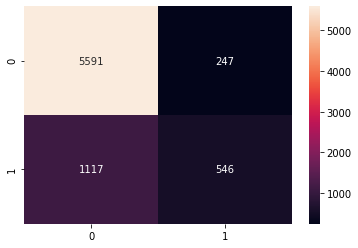

In [84]:
ax = sns.heatmap(confusion_matrix(lr_target, lr_pred), annot=True, fmt='d')

## Support Vector Machines Model

### Model Training

In [89]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC()
lsvc_model = lsvc.fit(train)

svm_predictions = lsvc_model.transform(test)
svm_predictions.columns

['features', 'label', 'rawPrediction', 'prediction']

In [90]:
lsvc.params

[Param(parent='LinearSVC_2bbc9f5dc116', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='featuresCol', doc='features column name.'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='labelCol', doc='label column name.'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='maxIter', doc='max number of iterations (>= 0).'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='predictionCol', doc='prediction column name.'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='regParam', doc='regularization parameter (>= 0).'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='standardization', doc='whether to standardize the training features before fitting the model.'),
 Param(parent='LinearSVC_2bbc9f5dc116', name='threshold

### Model Performance on Test Set

In [91]:
svm_predictions.select(['label', 'prediction']).show(10, False)

+-----+----------+
|label|prediction|
+-----+----------+
|1    |1.0       |
|1    |1.0       |
|1    |1.0       |
|1    |1.0       |
|1    |1.0       |
|0    |1.0       |
|0    |1.0       |
|1    |1.0       |
|0    |1.0       |
|1    |1.0       |
+-----+----------+
only showing top 10 rows



In [92]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
svc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
svc_auroc = svc_evaluator.evaluate(svm_predictions)
print(f'The auc value of SVC is {svc_auroc}')

The auc value of SVC is 0.7486244661173395


In [93]:
svc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
svc_aupr = svc_evaluator.evaluate(svm_predictions)
print(f'The aupr value for SVC is {svc_aupr}')

The aupr value for SVC is 0.5170700191595411


#### Recall and Precision

In [94]:
true_pos = svm_predictions.filter(svm_predictions['label']==1).filter(
    svm_predictions['prediction']==1).count()
print("True positives:", true_pos)

actual_pos = svm_predictions.filter(svm_predictions['label']==1).count()
print("Actual positives:", actual_pos)

pred_pos = svm_predictions.filter(svm_predictions['prediction']==1).count()
print("Predicted positives:", pred_pos)

print('Recall:', (float(true_pos)/(actual_pos)))

print('Precision:', (float(true_pos)/(pred_pos)))

True positives: 656
Actual positives: 1663
Predicted positives: 988
Recall: 0.39446782922429346
Precision: 0.6639676113360324


#### Confusion Matrix

In [95]:
from sklearn.metrics import confusion_matrix

svm_target = np.array(svm_predictions.select('label').collect())
svm_pred = np.array(svm_predictions.select('prediction').collect())

confusion_matrix(svm_target, svm_pred)

array([[5506,  332],
       [1007,  656]])

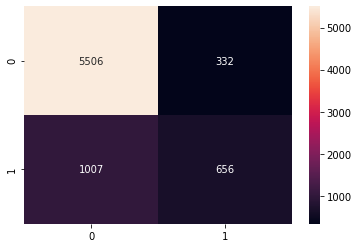

In [96]:
ax = sns.heatmap(confusion_matrix(svm_target, svm_pred), annot=True, fmt='d')

## Random Forest Model

### Model Training

In [118]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=30)
rf_model = rf.fit(train)

### Model Performance on Test Set

In [119]:
rf_predictions = rf_model.transform(test)
rf_predictions.select(['label', 'probability', 'prediction']).show(10, False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|1    |[0.3289660120424697,0.6710339879575303] |1.0       |
|1    |[0.23561835587780658,0.7643816441221934]|1.0       |
|1    |[0.23421734915467549,0.7657826508453245]|1.0       |
|1    |[0.23493191022628468,0.7650680897737153]|1.0       |
|1    |[0.23561835587780658,0.7643816441221934]|1.0       |
|0    |[0.23561835587780658,0.7643816441221934]|1.0       |
|0    |[0.33179757998320347,0.6682024200167966]|1.0       |
|1    |[0.42511171935408304,0.5748882806459169]|1.0       |
|0    |[0.336340026246194,0.6636599737538059]  |1.0       |
|1    |[0.42681901555259105,0.573180984447409] |1.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [120]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(rf_predictions)
print(f'The area under ROC value of Random Forest Classifier Model is {rf_auroc}')

The area under ROC value of Random Forest Classifier Model is 0.765648558380338


In [121]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_aupr = rf_evaluator.evaluate(rf_predictions)
print(f'The area under PR value of Random Forest Classifier Model is {rf_aupr}')

The area under PR value of Random Forest Classifier Model is 0.5406257852228511


#### Recall and Precision

In [122]:
true_pos = rf_predictions.filter(rf_predictions['label']==1).filter(
    rf_predictions['prediction']==1).count()
print('True positives:', true_pos)

actual_pos = rf_predictions.filter(rf_predictions['label']==1).count()
print('Actual positives:', actual_pos)

pred_pos = rf_predictions.filter(rf_predictions['prediction']==1).count()
print('Predicted positives:', pred_pos)

print('Recall:', float(true_pos)/(actual_pos))

print('Precision:', float(true_pos)/(pred_pos))

True positives: 553
Actual positives: 1663
Predicted positives: 793
Recall: 0.33253156945279616
Precision: 0.6973518284993695


#### Confusion Matrix

In [102]:
from sklearn.metrics import confusion_matrix

rf_target = np.array(rf_predictions.select('label').collect())
rf_pred = np.array(rf_predictions.select('prediction').collect())

confusion_matrix(rf_target, rf_pred)

array([[5545,  293],
       [1083,  580]])

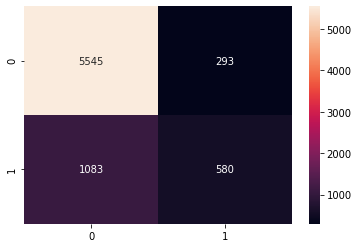

In [103]:
ax = sns.heatmap(confusion_matrix(rf_target, rf_pred), annot=True, fmt='d')

# Hyperparameter-Tuning

## Logistic Regression

In [124]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder().
             addGrid(logreg.threshold, [0.2, 0.4, 0.6, 0.8]).
             addGrid(logreg.elasticNetParam, [0, 1]).
             build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=lr_evaluator, numFolds=5)
cv_model = cv.fit(train)
best_lr_model = cv_model.bestModel

In [125]:
best_lr_model.params

[Param(parent='LogisticRegression_5c708e827b79', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_5c708e827b79', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_5c708e827b79', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_5c708e827b79', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_5c708e827b79', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_5c708e827b79', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_5c708e827b79', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound cons

## Random Forest Classifier

In [132]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder().
             addGrid(rf.maxDepth, [5, 10, 20, 30]).
             addGrid(rf.maxBins, [20, 50]).
             addGrid(rf.numTrees, [5, 20, 50]).
             build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, 
                    evaluator=rf_evaluator, numFolds=5)
cv_model = cv.fit(train)
best_rf_model = cv_model.bestModel

In [140]:
best_rf_model.params

[Param(parent='RandomForestClassifier_425566ed71c2', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'),
 Param(parent='RandomForestClassifier_425566ed71c2', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'),
 Param(parent='RandomForestClassifier_425566ed71c2', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'),
 Param(parent='RandomForestClassifier_425566ed71c2', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'a

# Final Test of the Model

## Logistic Regression

In [126]:
lr_predictions = best_lr_model.transform(test)

### Precision and Recall

In [128]:
true_pos = predictions.filter(predictions['label']==0).filter(
    predictions['prediction']==0).count()
print("True positives:", true_pos)

actual_pos = predictions.filter(predictions['label']==0).count()
print("Actual positives:", actual_pos)

pred_pos = predictions.filter(predictions['prediction']==0).count()
print("Predicted positives:", pred_pos)

print("Recall", float(true_pos)/(actual_pos))

print("Precision:", float(true_pos)/(pred_pos))

True positives: 5591
Actual positives: 5838
Predicted positives: 6708
Recall 0.9576909900650907
Precision: 0.8334824090638044


### Confusion Matrix

In [129]:
from sklearn.metrics import confusion_matrix

targ = np.array(predictions.select('label').collect())
pred = np.array(predictions.select('prediction').collect())

confusion_matrix(targ, pred)

array([[5591,  247],
       [1117,  546]])

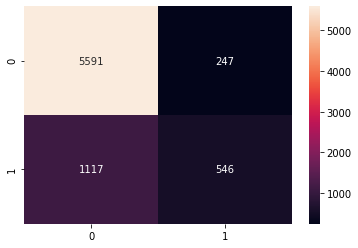

In [130]:
ax = sns.heatmap(confusion_matrix(targ, pred), annot=True, fmt='d')

## Random Forest Classifier

In [134]:
rf_predictions = best_rf_model.transform(test)

In [135]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(rf_predictions)
print(f'The area under ROC value of Random Forest Classifier Model is {rf_auroc}')

The area under ROC value of Random Forest Classifier Model is 0.7729085694591825


In [136]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_aupr = rf_evaluator.evaluate(rf_predictions)
print(f'The area under PR value of Random Forest Classifier Model is {rf_aupr}')

The area under PR value of Random Forest Classifier Model is 0.5547414186621317


### Precision and Recall

In [137]:
true_pos = rf_predictions.filter(rf_predictions['label']==1).filter(
    rf_predictions['prediction']==1).count()
print('True positives:', true_pos)

actual_pos = rf_predictions.filter(rf_predictions['label']==1).count()
print('Actual positives:', actual_pos)

pred_pos = rf_predictions.filter(rf_predictions['prediction']==1).count()
print('Predicted positives:', pred_pos)

print('Recall:', float(true_pos)/(actual_pos))

print('Precision:', float(true_pos)/(pred_pos))

True positives: 580
Actual positives: 1663
Predicted positives: 846
Recall: 0.34876728803367407
Precision: 0.6855791962174941


### Confusion Matrix

In [138]:
from sklearn.metrics import confusion_matrix

rf_target = np.array(rf_predictions.select('label').collect())
rf_pred = np.array(rf_predictions.select('prediction').collect())

confusion_matrix(rf_target, rf_pred)

array([[5572,  266],
       [1083,  580]])

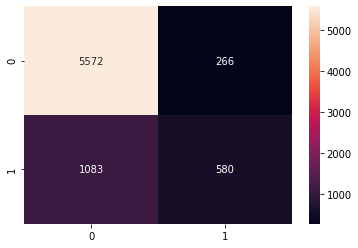

In [139]:
ax = sns.heatmap(confusion_matrix(rf_target, rf_pred), annot=True, fmt='d')

# Summary

As we can see, the model that better performed for this task was the Logistic Regression model, with this results:

* Precision: `0.83`
* Recall: `0.95`

We have to take into account that the bank may have two different intentions for this data: predict the default of their clients or prevent it. 

For this first intention, I should tweak the model so it has fewer false negatives. Thus the bank has more accurate information about the condition of its customers.

And for the second, the bank needs more false positives, so the bank can assist its clients in time and prevent them from going into default.

# Future Work/Next Steps

In the future, I could try more models, like:
* Normalized Linear Regression
  * Ridge Regression
  * Lasso Regression
* Neural Networks

With their respective hyperparameter tuning.

Also, I could use a bigger dataset (+30000 samples), in this way we will have more training examples and the final result of the test will be more reliable.


